In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

import util
from public_tests import *
from test_utils import *

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [90]:
train_df = pd.read_csv("D:/Xray_Data/data/PruneCXR/miccai2023_nih-cxr-lt_labels_train.csv")
valid_df = pd.read_csv("D:/Xray_Data/data/PruneCXR/miccai2023_nih-cxr-lt_labels_val.csv")

test_df = pd.read_csv("D:/Xray_Data/data/PruneCXR/miccai2023_nih-cxr-lt_labels_test.csv")

train_df.head()

,id,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,...,Pleural Thickening,Pneumonia,Pneumothorax,Pneumoperitoneum,Pneumomediastinum,Subcutaneous Emphysema,Tortuous Aorta,Calcification of the Aorta,No Finding,subj_id
0,00000001_000.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,00000001_001.png,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,00000001_002.png,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,00000002_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
4,00000004_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [91]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
        'No Finding']

In [92]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78506 entries, 0 to 78505
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   id                          78506 non-null  object
 1   Atelectasis                 78506 non-null  int64 
 2   Cardiomegaly                78506 non-null  int64 
 3   Consolidation               78506 non-null  int64 
 4   Edema                       78506 non-null  int64 
 5   Effusion                    78506 non-null  int64 
 6   Emphysema                   78506 non-null  int64 
 7   Fibrosis                    78506 non-null  int64 
 8   Hernia                      78506 non-null  int64 
 9   Infiltration                78506 non-null  int64 
 10  Mass                        78506 non-null  int64 
 11  Nodule                      78506 non-null  int64 
 12  Pleural Thickening          78506 non-null  int64 
 13  Pneumonia                   78506 non-null  in

In [93]:
print(f"The total patient ids are {train_df['subj_id'].count()}, from those the unique ids are {train_df['subj_id'].value_counts().shape[0]} ")

The total patient ids are 78506, from those the unique ids are 24507 


In [94]:
columns = train_df.keys()
columns = list(columns)
print(columns)

['id', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural Thickening', 'Pneumonia', 'Pneumothorax', 'Pneumoperitoneum', 'Pneumomediastinum', 'Subcutaneous Emphysema', 'Tortuous Aorta', 'Calcification of the Aorta', 'No Finding', 'subj_id']


In [ ]:
''

In [42]:
def check_for_leakage(df1, df2, patient_col):
   
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    
    leakage = len(patients_in_both_groups) > 0 
    
    
    
    return leakage

In [43]:
check_for_leakage_test(check_for_leakage)

Test Case 1

df1
   patient_id
0           0
1           1
2           2
df2
   patient_id
0           2
1           3
2           4
leakage output: True 
-------------------------------------
Test Case 2

df1
   patient_id
0           0
1           1
2           2
df2
   patient_id
0           3
1           4
2           5
leakage output: False 

 All tests passed.


In [44]:
print("leakage between train and valid: {}".format(check_for_leakage(train_df, valid_df, 'subj_id')))
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'subj_id')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'subj_id')))

leakage between train and valid: False
leakage between train and test: False
leakage between valid and test: False


In [45]:

def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    
    print("getting train generator...") 
    
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator


In [46]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    
    print("getting train and valid generators...")
    
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="id", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
   
    batch = raw_train_generator.next()
    data_sample = batch[0]

   
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
   
    image_generator.fit(data_sample)

    
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [47]:
IMAGE_DIR = "D:/Xray_Data/data/images_2/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "id", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "id", labels)

getting train generator...
Found 78506 validated image filenames.
getting train and valid generators...
Found 78506 validated image filenames.
Found 12533 validated image filenames.
Found 21081 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


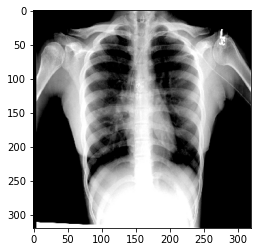

In [48]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

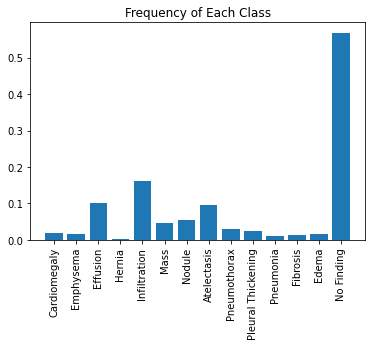

In [49]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [50]:

def compute_class_freqs(labels):
   
    N = labels.shape[0]
    
    
    positive_frequencies = np.sum(labels, axis=0) / N
    
    
    negative_frequencies = 1 - positive_frequencies

    
    return positive_frequencies, negative_frequencies

In [51]:
compute_class_freqs_test(compute_class_freqs)

Labels:
[[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]

Pos Freqs:  [0.8 0.4 0.8]
Neg Freqs:  [0.2 0.6 0.2] 

 All tests passed.


In [52]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02025323, 0.01690317, 0.10087127, 0.00165592, 0.16226785,
       0.04699004, 0.05552442, 0.09664229, 0.03097852, 0.02545028,
       0.01026673, 0.01449571, 0.0163427 , 0.56842789])

C:\Users\GHOST\AppData\Local\Temp\ipykernel_2632\2978771470.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)


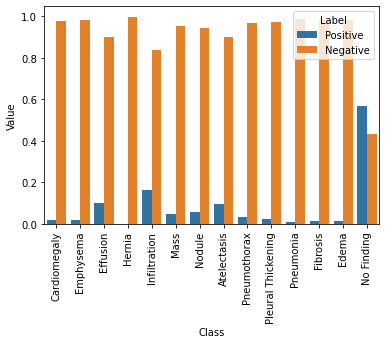

In [53]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [54]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

C:\Users\GHOST\AppData\Local\Temp\ipykernel_2632\4211278599.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v}


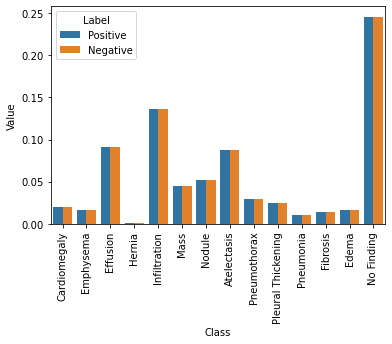

In [55]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [56]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (float): overall scalar loss summed across all classes
        """
        # Initialize loss to zero
        loss = 0.0
        
        ### START CODE HERE ###

        for i in range(len(pos_weights)):
            # For each class, add average weighted loss for that class 
            loss += - K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon) + neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            
        ### END CODE HERE ###
        return loss
    
    return weighted_loss

In [79]:
# test with a large epsilon in order to catch errors. 
# In order to pass the tests, set epsilon = 1
epsilon = 1

### do not edit anything below
sess = K.get_session()
get_weighted_loss_test(get_weighted_loss, epsilon, sess)

NotImplementedError: eval is not supported when eager execution is enabled, is .numpy() what you're looking for?

In [80]:
def get_weighted_loss_test_case(sess=None):
    y_true = np.array([[1, 0], [0, 1]])
    w_p = np.array([0.5, 0.5])
    w_n = np.array([0.4, 0.6])
    y_pred_1 = 0.7 * np.ones(y_true.shape)
    y_pred_2 = 0.3 * np.ones(y_true.shape)
    return y_true, w_p, w_n, y_pred_1, y_pred_2


In [82]:
get_weighted_loss_test(get_weighted_loss, epsilon, sess)


NotImplementedError: eval is not supported when eager execution is enabled, is .numpy() what you're looking for?

In [60]:

base_model = DenseNet121(weights="D:/Xray_Data/data/small_data/Files/home/jovyan/work/W1A1/models/nih/densenet.hdf5", include_top=False)

x = base_model.output


x = GlobalAveragePooling2D()(x)


predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

In [61]:
model.load_weights("D:/Xray_Data/data/small_data/Files/home/jovyan/work/W1A1/models/nih/pretrained_model.h5")

In [62]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

C:\Users\GHOST\AppData\Local\Temp\ipykernel_2632\2146632228.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))


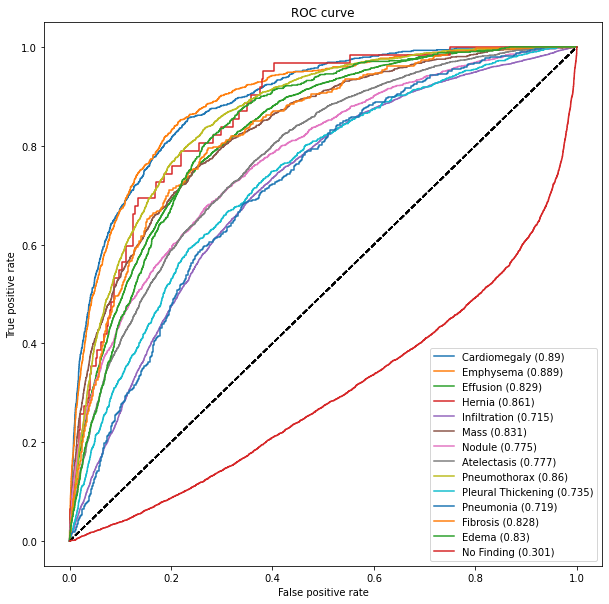

In [63]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

In [95]:
df = pd.read_csv("D:/Xray_Data/data/PruneCXR/miccai2023_nih-cxr-lt_labels_train.csv")
IMAGE_DIR = "D:/Xray_Data/data/images_2/"

# only show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

In [96]:
util.compute_gradcam(model, 'D:/Xray_Data/data/images_2/00000006_000.png', IMAGE_DIR, df, labels, labels_to_show)

KeyError: 'Image'

In [100]:
df = pd.read_csv("D:/Xray_Data/data/small_data/Files/home/jovyan/work/W1A1/data/nih/train-small.csv")
IMAGE_DIR = "D:/Xray_Data/data/small_data/Files/home/jovyan/work/W1A1/data/nih/images-small/"

# only show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

In [101]:
util.compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show)

AttributeError: module 'keras.preprocessing.image' has no attribute 'load_img'